# Education Data Analysis - Birth month vs Grades

Cleaned pipeline with proper decimal conversion for grade columns.

Generalized for all main primary and secondary "shared" subjects.

## 0. Importing, reading, cleaning

Execute this cells one by one or your kernell might die

In [1]:
import psutil
print(psutil.virtual_memory())

svmem(total=34359738368, available=13786701824, percent=59.9, used=18430869504, free=33157120, active=13759053824, inactive=13725564928, wired=4671815680)


In [2]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress  # for linear regression


In [3]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [4]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [81]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

# Keep only students present in both datasets
students_P = set(df_P['CODI_ALUMNE'].unique())
students_S = set(df_S['CODI_ALUMNE'].unique())

# Find matching students
matching_students = students_P.intersection(students_S)

print(f"Students in Primary: {len(students_P)}")
print(f"Students in Secondary: {len(students_S)}")
print(f"Matching students: {len(matching_students)}")

# Filter both dataframes
df_P = df_P[df_P['CODI_ALUMNE'].isin(matching_students)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching_students)].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

# Clear memory
gc.collect()


Students in Primary: 513377
Students in Secondary: 532090
Matching students: 251748


0

In [5]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    Optimized for large datasets with memory management.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    print(f"Found {len(grade_cols)} columns to convert...")
    
    for i, col in enumerate(grade_cols):
        try:
            # Replace comma with dot for decimal conversion
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            # Convert to numeric (invalid parsing becomes NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            if (i + 1) % 5 == 0:  # Progress check every 5 columns
                print(f"  Converted {i + 1}/{len(grade_cols)} columns...")
                gc.collect()
        
        except Exception as e:
            print(f"  Warning: Could not convert column {col}: {e}")
            continue
    
    return grade_cols


# Apply conversion separately to Primary and Secondary
print("Converting Primary grades...")
converted_P = convert_grades_to_numeric(df_P, prefix='P')
gc.collect()

print("Converting Secondary grades...")
converted_S = convert_grades_to_numeric(df_S, prefix='P')
gc.collect()

print(f"\nConverted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")


Converting Primary grades...
Found 24 columns to convert...
  Converted 5/24 columns...
  Converted 10/24 columns...
  Converted 15/24 columns...
  Converted 20/24 columns...
Converting Secondary grades...
Found 28 columns to convert...
  Converted 5/28 columns...
  Converted 10/28 columns...
  Converted 15/28 columns...
  Converted 20/28 columns...
  Converted 25/28 columns...

Converted 24 columns in Primary
Converted 28 columns in Secondary


In [61]:
# Import color palette
plt.style.use("itxaso.mplstyle")

In [60]:
# ========== PRIMARY-SECONDARY COLOR PALETTE ==========

palette = {
    'primary': {
        # mid between primary male blue and primary female teal
        'points': '#2B7180',                 # real means + regression line
        'thermalized_band': '#92CFD0',       # light aqua band
        'thermalized_mean_line': '#008C8C',  # teal-blue null mean line
    },
    'secondary': {
        # mid between secondary male violet and secondary female orange
        'points': '#8A3C6A',                 # plum / magenta-brown
        'thermalized_band': '#F1B7D0',       # light rose band
        'thermalized_mean_line': '#B1447E',  # strong magenta-plum line
    }
}


## 1. Initial plots

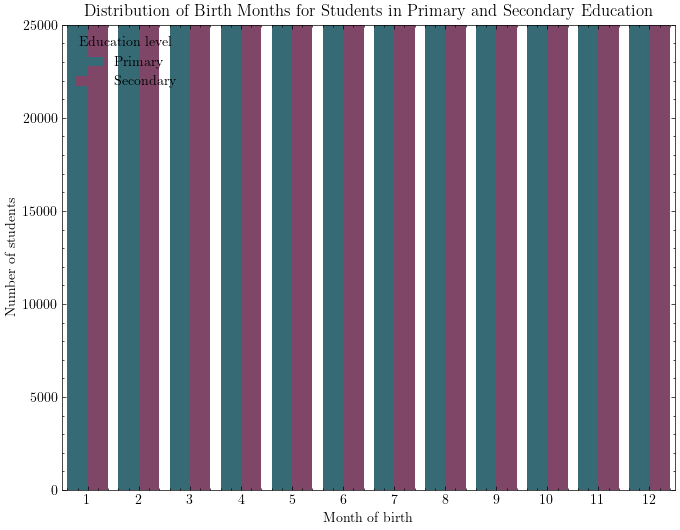

In [59]:
plt.style.use("itxaso.mplstyle")

# ===============================
# Plot 1: Distribution of Birth Months
# ===============================
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting only
df_birth_months = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(
    df_birth_months['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# Use point colors from palette
hue_order = ['Primary', 'Secondary']
birth_palette = {
    'Primary':   palette['primary']['points'],
    'Secondary': palette['secondary']['points'],
}  # maps hue values to custom hex colors

fig, ax = plt.subplots()

sns.countplot(
    data=df_birth_months,
    x='MES_NAIXEMENT',
    hue='snapshot',
    hue_order=hue_order,
    palette=birth_palette,   # apply your custom colors
    ax=ax
)

# Set yrange from 0 to 25000
ax.set_ylim(0, 25000)

ax.set_title('Distribution of Birth Months for Students in Primary and Secondary Education')
ax.set_xlabel('Month of birth')
ax.set_ylabel('Number of students')
ax.legend(title='Education level', loc='upper left')

fig.savefig(os.path.join(plot_dir, filename), dpi=600, bbox_inches='tight')
fig.tight_layout()
plt.show()


PRIMARY EDUCATION - Mathematics (PMAT)
Total students: 513377
Mean grade: 76.26
Median grade: 79.57
Std Dev: 16.87
Min: 0.00
Max: 100.00
25th percentile: 66.33
75th percentile: 89.11

SECONDARY EDUCATION - Mathematics (PMAT)
Total students: 532090
Mean grade: 65.96
Median grade: 68.29
Std Dev: 22.11
Min: 0.00
Max: 100.00
25th percentile: 50.08
75th percentile: 83.89



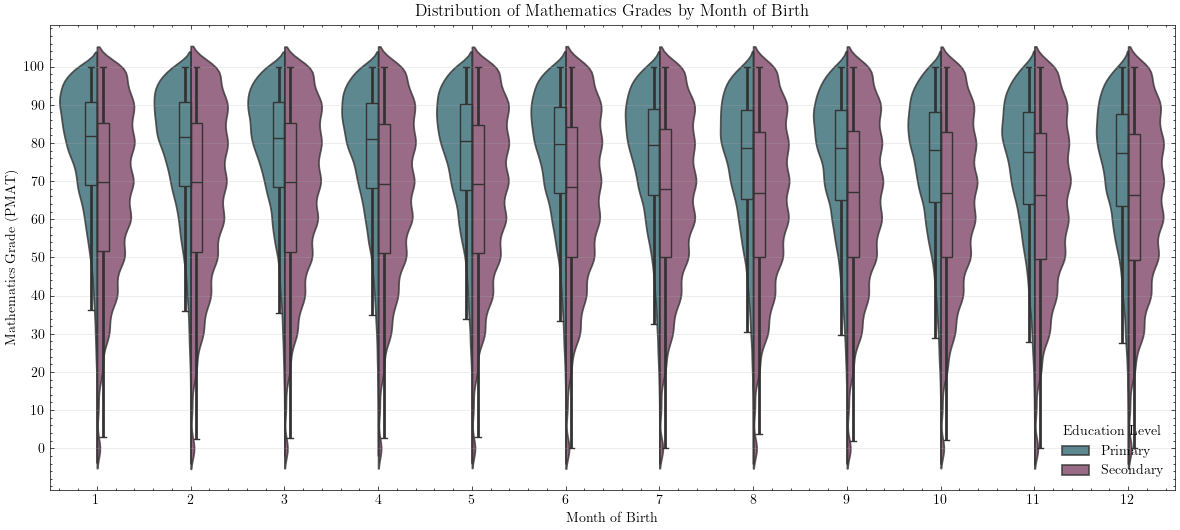

In [12]:
# ===============================
# Analysis: Primary Education
# ===============================
df_math_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_P['MES_NAIXEMENT'] = pd.Categorical(df_math_P['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_P['snapshot'] = 'Primary'

# Summary statistics for Primary
print("=" * 50)
print("PRIMARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_P)}")
print(f"Mean grade: {df_math_P['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_P['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_P['PMAT'].std():.2f}")
print(f"Min: {df_math_P['PMAT'].min():.2f}")
print(f"Max: {df_math_P['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_P['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_P['PMAT'].quantile(0.75):.2f}")
print()


# ===============================
# Analysis: Secondary Education
# ===============================
df_math_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_S['MES_NAIXEMENT'] = pd.Categorical(df_math_S['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_S['snapshot'] = 'Secondary'

# Summary statistics for Secondary
print("=" * 50)
print("SECONDARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_S)}")
print(f"Mean grade: {df_math_S['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_S['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_S['PMAT'].std():.2f}")
print(f"Min: {df_math_S['PMAT'].min():.2f}")
print(f"Max: {df_math_S['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_S['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_S['PMAT'].quantile(0.75):.2f}")
print()


plt.style.use("itxaso.mplstyle")

# ===============================
# Plot 2: Mathematics Grades by Birth Month (Violin Distribution)
# ===============================
plt.figure(figsize=(12, 5.5))

# Combine dataframes for plotting only
df_math_grades = pd.concat([df_math_P, df_math_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_math_grades['MES_NAIXEMENT'] = pd.Categorical(
    df_math_grades['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# Color mapping using your point colors
hue_order = ['Primary', 'Secondary']
math_palette = {
    'Primary':   palette['primary']['points'],
    'Secondary': palette['secondary']['points'],
}

# Violin layer
sns.violinplot(
    data=df_math_grades,
    x='MES_NAIXEMENT',
    y='PMAT',
    hue='snapshot',
    hue_order=hue_order,
    palette=math_palette,  
    alpha=0.8,
    split=True,
    inner=None
)

# Box layer (outline only), using same hue mapping
sns.boxplot(
    data=df_math_grades,
    x='MES_NAIXEMENT',
    y='PMAT',
    hue='snapshot',
    hue_order=hue_order,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 3},
    showfliers=False,
    whiskerprops={'linewidth': 2},
    width=0.25,
    palette=math_palette
)

# Fix duplicate legends (violin + box)
handles, labels = plt.gca().get_legend_handles_labels()
# first two entries correspond to 'Primary','Secondary' from the first layer
plt.legend(handles[:2], labels[:2], title='Education Level', loc='best')

# Set y-axis ticks every 10 points
plt.yticks(range(0, 101, 10))

plt.title('Distribution of Mathematics Grades by Month of Birth')
plt.xlabel('Month of Birth')
plt.ylabel('Mathematics Grade (PMAT)')
plt.grid(axis='y', alpha=0.3)
fig.savefig(os.path.join(plot_dir, filename), dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [19]:
plt.style.use("itxaso.mplstyle")

# ===============================
# Prepare combined Catalan dataframe
# ===============================
df_cat_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PCAT']].drop_duplicates('CODI_ALUMNE')
df_cat_P['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_P['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)
df_cat_P['snapshot'] = 'Primary'

df_cat_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PCAT']].drop_duplicates('CODI_ALUMNE')
df_cat_S['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_S['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)
df_cat_S['snapshot'] = 'Secondary'

df_cat_grades = pd.concat([df_cat_P, df_cat_S], ignore_index=True)

df_cat_grades['MES_NAIXEMENT'] = pd.Categorical(
    df_cat_grades['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

hue_order = ['Primary', 'Secondary']
cat_palette = {
    'Primary':   palette['primary']['points'],
    'Secondary': palette['secondary']['points'],
}


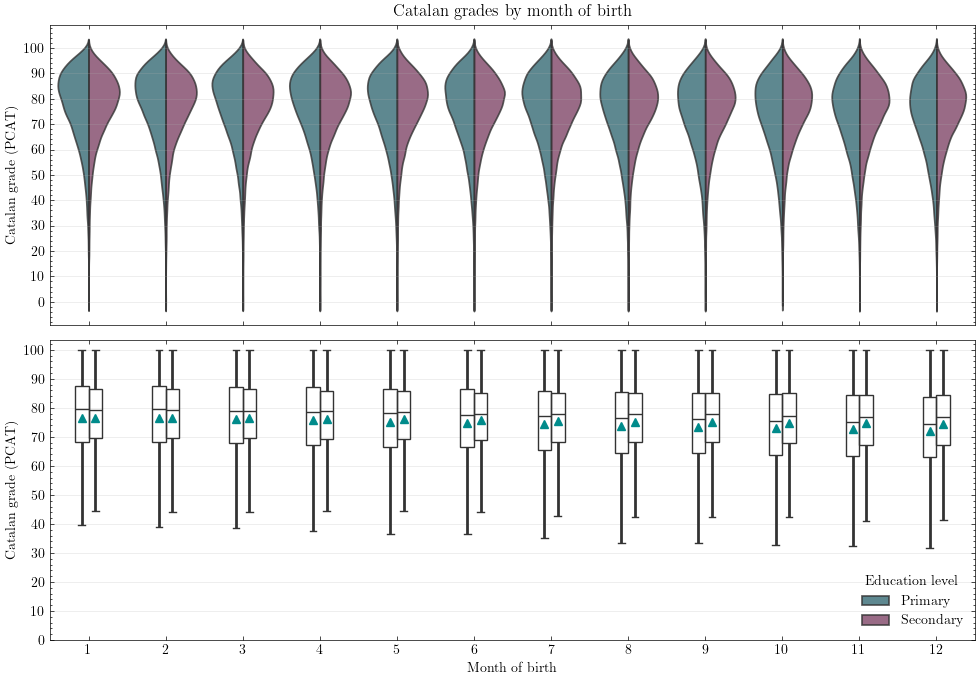

In [63]:
# ===============================
# Multiplot: violins (top) + boxes (bottom)
# ===============================
fig, (ax_violin, ax_box) = plt.subplots(
    2, 1,
    figsize=(10, 7),
    sharex=True
)

# --- Top: violin distributions ---
sns.violinplot(
    data=df_cat_grades,
    x='MES_NAIXEMENT',
    y='PCAT',
    hue='snapshot',
    hue_order=hue_order,
    palette=cat_palette,
    alpha=0.8,
    split=True,
    inner=None,
    ax=ax_violin
)

handles, labels = ax_violin.get_legend_handles_labels()

ax_violin.set_ylabel('Catalan grade (PCAT)')
ax_violin.set_title('Catalan grades by month of birth')


# --- Bottom: boxplots only ---
sns.boxplot(
    data=df_cat_grades,
    x='MES_NAIXEMENT',
    y='PCAT',
    hue='snapshot',
    hue_order=hue_order,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 3},
    showfliers=False,
    whiskerprops={'linewidth': 2},
    width=0.35,
    palette=cat_palette,
    ax=ax_box,
    showmeans=True, meanprops={'label': 'mean'}
)

ax_box.legend_.remove()

ax_box.set_ylabel('Catalan grade (PCAT)')
ax_box.set_xlabel('Month of birth')

ax_violin.set_yticks(range(0, 101, 10))
ax_box.set_yticks(range(0, 101, 10))

for ax in (ax_violin, ax_box):
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', which='minor', length=0)

plt.tight_layout()

# Get handles/labels from the top axis (violin)
handles, labels = ax_violin.get_legend_handles_labels()

# Remove legend from top axis
ax_violin.legend_.remove()

# Add legend to bottom axis, bottom-right
ax_box.legend(
    handles[:2], labels[:2],
    title='Education level',
    loc='lower right'
)

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)
filename = "violin_box_multiplot_catalan_primary_secondary_.png"
fig.savefig(os.path.join(plot_dir, filename), dpi=600, bbox_inches='tight')

plt.show()

## 2. Generalization: computing average grades with thermalization

Compute the error bars to the values. Also, when you do the thermalization, do a sigma, differenciate between the area of the biggest % of the lines and the one ouside. You will do that later by doing the fill in between with two grades of opacity. So that way, Im not only taking the maximum and the minimum y values, but seeing in this noise distribution what is relevant and what not.

In [87]:
# MAIN SUBJECTS:
subjects = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN', 'PMED']

subjects_P = [s for s in subjects if s in df_P.columns]
subjects_S = [s for s in subjects if s in df_S.columns]

print("Primary subjects:", subjects_P)
print("Secondary subjects:", subjects_S)


Primary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
Secondary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']


### Implement a randomization of the data and added statistics

In [8]:
# --------------------------------------------------------
# 1. Thermalize one subject, with errors for the means
# --------------------------------------------------------
def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)

    Returns
    -------
    summary : DataFrame with month-level stats (months 1..12):
        month,
        real_mean       : empirical mean grade
        real_std        : sample standard deviation of grades in that month
        real_n          : number of students in that month
        real_sem        : standard error of the mean = real_std / sqrt(real_n)
        null_mean       : mean of null distribution (randomized months)
        null_std        : std of null distribution
        null_median     : median of null distribution
        q1, q3, iqr     : quartiles and IQR of null distribution
        z_score         : (real_mean - null_mean) / null_std
        z_iqr           : (real_mean - null_median) / iqr
        band_min, band_max : min / max of null means
        band_p16, band_p84 : ~68 % central band of null
        band_p2_5, band_p97_5 : ~95 % central band of null

    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (columns = months 1..12)
    """

    # Clean and keep only needed columns
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df[grade_col] = pd.to_numeric(df[grade_col], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # --- Real statistics per month (full 1..12 grid) ---
    grp = (
        df.groupby('MES_NAIXEMENT')[grade_col]
        .agg(['mean', 'std', 'count'])
        .reindex(months)
    )

    real_mean = grp['mean'].values
    real_std  = grp['std'].values
    real_n    = grp['count'].values

    real_sem = np.where(real_n > 0, real_std / np.sqrt(real_n), np.nan)

    # --- Simulations: null distribution via month randomization ---
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # --- Null distribution summaries over simulations ---
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Bands for visualization
    band_min   = np.nanmin(sim, axis=0)
    band_max   = np.nanmax(sim, axis=0)
    band_p16   = np.nanpercentile(sim, 16,  axis=0)
    band_p84   = np.nanpercentile(sim, 84,  axis=0)
    band_p2_5  = np.nanpercentile(sim, 2.5, axis=0)
    band_p97_5 = np.nanpercentile(sim, 97.5, axis=0)

    summary = pd.DataFrame({
        'month':       months,
        'real_mean':   real_mean,
        'real_std':    real_std,
        'real_n':      real_n,
        'real_sem':    real_sem,
        'null_mean':   null_mean,
        'null_std':    null_std,
        'null_median': null_med,
        'q1':          q1,
        'q3':          q3,
        'iqr':         iqr,
        'z_score':     z,
        'z_iqr':       z_iqr,
        'band_min':    band_min,
        'band_max':    band_max,
        'band_p16':    band_p16,
        'band_p84':    band_p84,
        'band_p2_5':   band_p2_5,
        'band_p97_5':  band_p97_5,
    })

    return summary, sim


In [ ]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# 1. Run analysis for all subjects
# --------------------------------------------------------
primary_summaries = {}   # dict: subj -> summary DataFrame
primary_sims = {}        # dict: subj -> sim array
all_summaries = []

for subj in subjects_P:
    # Base dataframe for this subject in Primary
    df_subj_P = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    # Thermalization by month (uses new function with real_mean, real_sem, bands, etc.)
    summary_P, sim_P = thermalize_subject_by_month(
        df_level=df_subj_P,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=42
    )

    summary_P['subject'] = subj
    summary_P['snapshot'] = 'Primary'

    primary_summaries[subj] = summary_P
    primary_sims[subj] = sim_P
    all_summaries.append(summary_P)

# Long-format dataset with all Primary stats (all subjects, all months)
# Includes real_mean, real_std, real_n, real_sem, bands, z_score, z_iqr, etc.
df_stats_primary_all = pd.concat(all_summaries, ignore_index=True)


### Plots

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36463/87002375.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


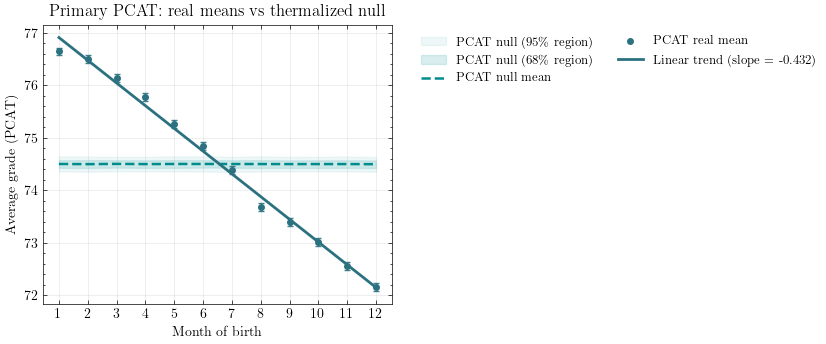

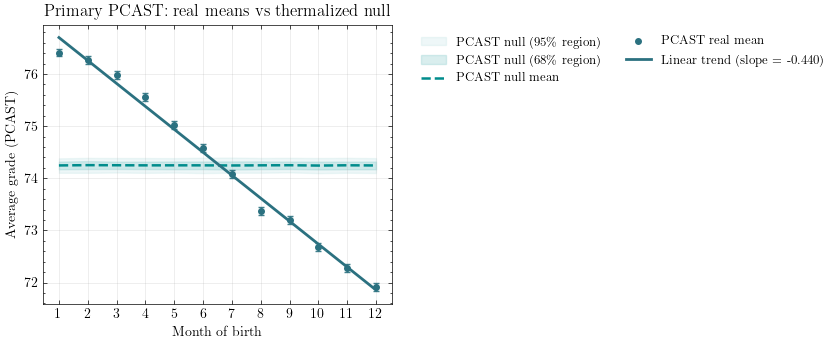

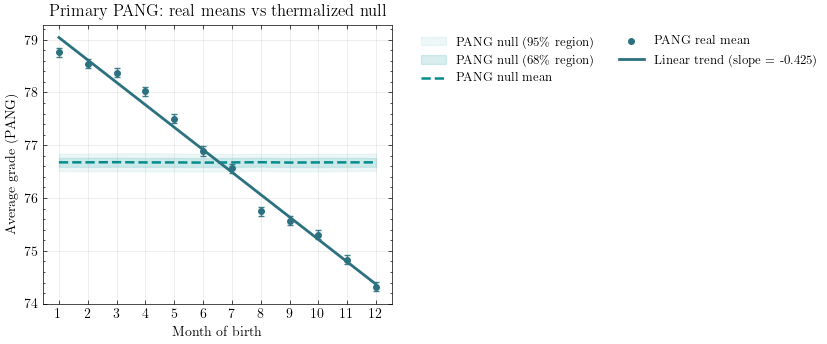

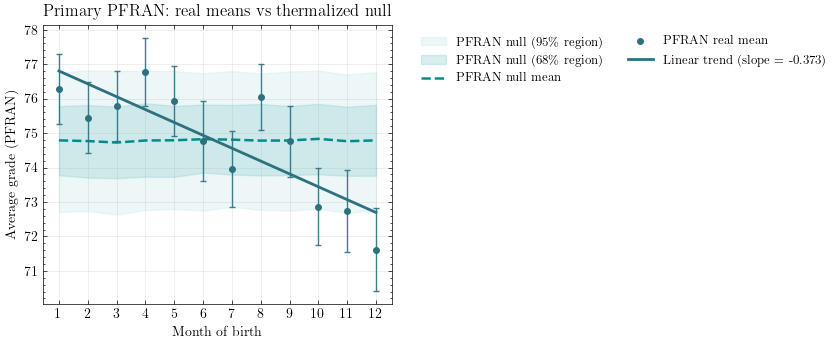

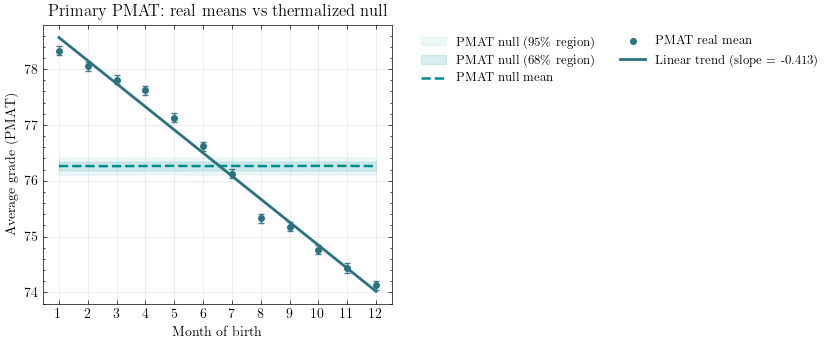

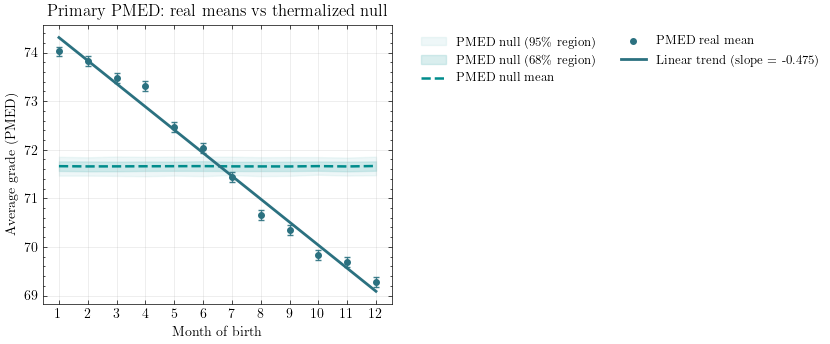

In [46]:
plt.style.use("itxaso.mplstyle")

# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# 3. Plot and save all subjects (Primary)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_P:
    summary_P = primary_summaries[subj]

    months     = summary_P['month'].values
    real_mean  = summary_P['real_mean'].values
    real_std   = summary_P['real_std'].values     # <-- spread of grades, what you want
    band_min   = summary_P['band_min'].values
    band_max   = summary_P['band_max'].values
    band_mean  = summary_P['null_mean'].values
    band_p16   = summary_P['band_p16'].values     # ≈ 16th percentile (inner band)
    band_p84   = summary_P['band_p84'].values     # ≈ 84th percentile
    band_p2_5  = summary_P['band_p2_5'].values    # ≈ 2.5th percentile (outer band)
    band_p97_5 = summary_P['band_p97_5'].values   # ≈ 97.5th percentile

    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    # Colors from your palette dict
    band_color  = palette['primary']['thermalized_band']
    mean_color  = palette['primary']['thermalized_mean_line']
    point_color = palette['primary']['points']

    # ----- Outer thermalized band (~95% central region of null) -----
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15,
        label=f'{subj} null (95\% region)'
    )

    # ----- Inner thermalized band (~68% central region of null) -----
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35,
        label=f'{subj} null (68\% region)'
    )

    # Optional absolute envelope
    # ax.fill_between(months, band_min, band_max, color=band_color, alpha=0.05)

    # Thermalized mean line (null mean)
    ax.plot(
        months, band_mean,
        linestyle='--', linewidth=1.8,
        color=mean_color,
        marker=None,
        label=f'{subj} null mean'
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label=f'{subj} real mean'
    )

    real_sem = real_std / np.sqrt(summary_P['real_n'].values)
    # Error bars for real means: ± standard deviation of grades
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,          # choose
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=f'Linear trend (slope = {slope:.3f})'
        )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real means vs thermalized null')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()

    for ax in (fig.axes):
        ax.tick_params(axis='x', which='minor', length=0)

    filename = f"primary_{subj}_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=600, bbox_inches='tight')

    plt.show()
    plt.close(fig)


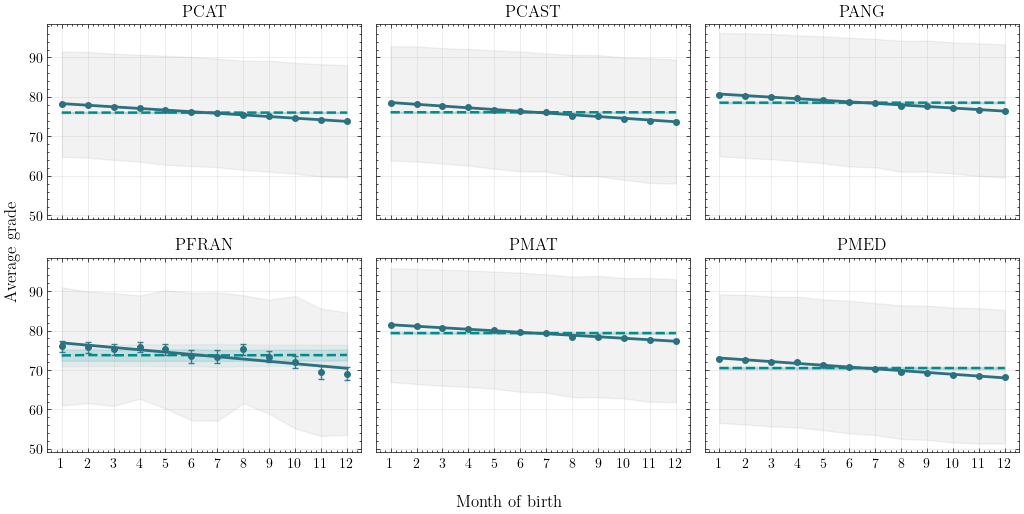

In [ ]:
plt.style.use("itxaso.mplstyle")

#--------------------------
#       MULTIPLOT
#--------------------------

# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# Multiplot for all Primary subjects (no legends)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

n_subj = len(subjects_P)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True, sharey=True
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_P):
    summary_P = primary_summaries[subj]

    months     = summary_P['month'].values
    real_mean  = summary_P['real_mean'].values
    real_std   = summary_P['real_std'].values   # spread of grades
    band_mean  = summary_P['null_mean'].values
    band_p16   = summary_P['band_p16'].values
    band_p84   = summary_P['band_p84'].values
    band_p2_5  = summary_P['band_p2_5'].values
    band_p97_5 = summary_P['band_p97_5'].values

    # Colors from your palette dict
    band_color  = palette['primary']['thermalized_band']
    mean_color  = palette['primary']['thermalized_mean_line']
    point_color = palette['primary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15
    )

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35
    )

    # Thermalized mean line
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color
    )

    real_sem = real_std / np.sqrt(summary_P['real_n'].values)
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    ax.fill_between(
        months,
        real_mean - real_std,
        real_mean + real_std,
        color='grey',    
        alpha=0.1,
        label='Real ± 1 SD'
    )

    # Linear regression on real means
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None
        )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Hide unused axes if any
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

fig.tight_layout()
for ax in (fig.axes):
    ax.tick_params(axis='x', which='minor', length=0)

fig.savefig(
    os.path.join(plot_dir, "primary_all_subjects_multiplot.png"),
    dpi=600,
    bbox_inches='tight'
)
plt.show()


In [10]:
#--------------------------
# SECONDARY MAIN SUBJECTS
#--------------------------
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
n_iter = 2000

# --------------------------------------------------------
# 2. Run analysis for all subjects
# --------------------------------------------------------
secondary_summaries = {}
secondary_sims = {}

for subj in subjects_S:
    df_subj_S = (
        df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    summary_S, sim_S = thermalize_subject_by_month(
        df_level=df_subj_S,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=84  # different seed from Primary if you want
    )

    summary_S['subject'] = subj
    summary_S['snapshot'] = 'Secondary'

    secondary_summaries[subj] = summary_S
    secondary_sims[subj] = sim_S

# Long-format dataset with all Secondary stats
df_stats_secondary_all = pd.concat(secondary_summaries.values(), ignore_index=True)



/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36463/3606240376.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


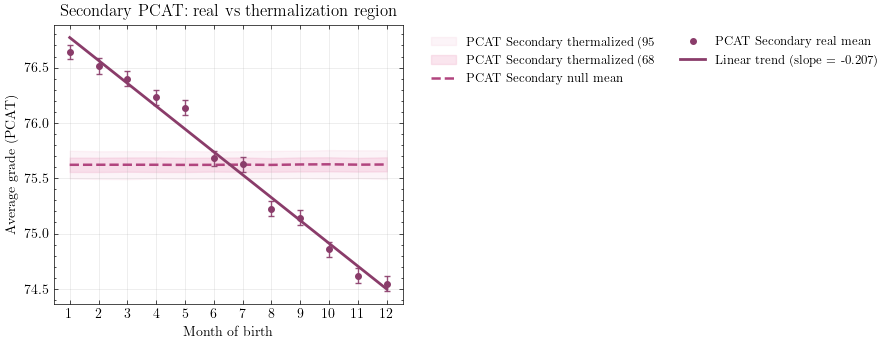

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36463/3606240376.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


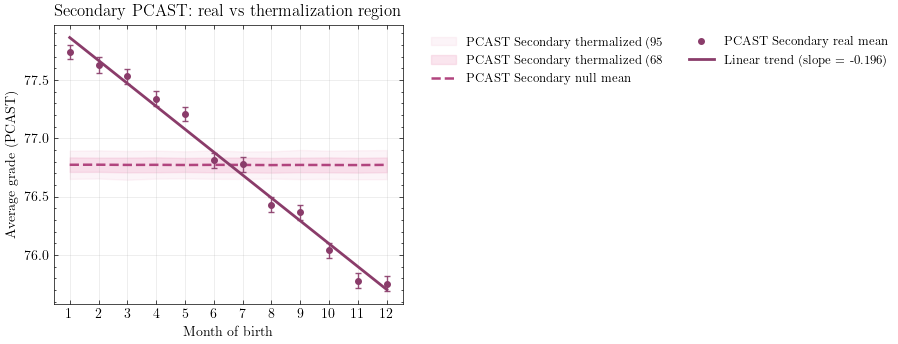

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36463/3606240376.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


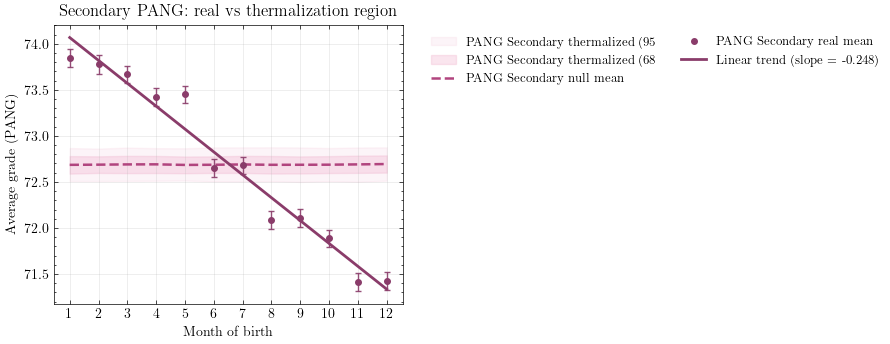

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36463/3606240376.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


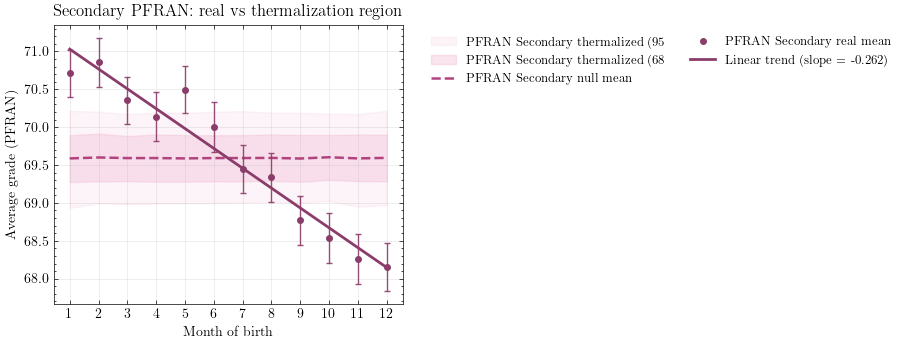

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36463/3606240376.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


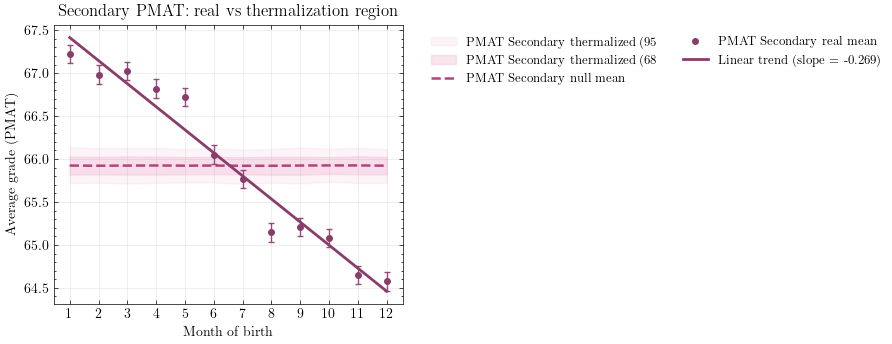

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36463/3606240376.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


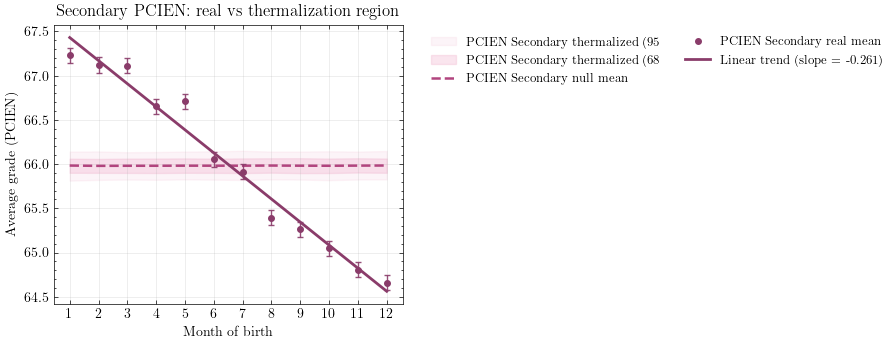

In [37]:
plt.style.use("itxaso.mplstyle")

# --------------------------------------------------------
# 3. Plot for all subjects (Secondary)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_S:
    summary_S = secondary_summaries[subj]

    months     = summary_S['month'].values
    real_mean  = summary_S['real_mean'].values
    real_std   = summary_S['real_std'].values    # spread of grades
    band_mean  = summary_S['null_mean'].values
    band_p16   = summary_S['band_p16'].values
    band_p84   = summary_S['band_p84'].values
    band_p2_5  = summary_S['band_p2_5'].values
    band_p97_5 = summary_S['band_p97_5'].values

    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    # Colors from your palette dict
    band_color  = palette['secondary']['thermalized_band']
    mean_color  = palette['secondary']['thermalized_mean_line']
    point_color = palette['secondary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15,
        label=f'{subj} Secondary thermalized (95\% region)'
    )

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35,
        label=f'{subj} Secondary thermalized (68\% region)'
    )

    # Thermalized mean line
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None,
        label=f'{subj} Secondary null mean'
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label=f'{subj} Secondary real mean'
    )

    real_sem = real_std / np.sqrt(summary_S['real_n'].values)
    # Error bars on real means: ± standard deviation of grades
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    # Linear regression on real means
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=f'Linear trend (slope = {slope:.3f})'
        )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Secondary {subj}: real vs thermalization region')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    for ax in (fig.axes):
        ax.tick_params(axis='x', which='minor', length=0)

    filename = f"secondary_{subj}_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


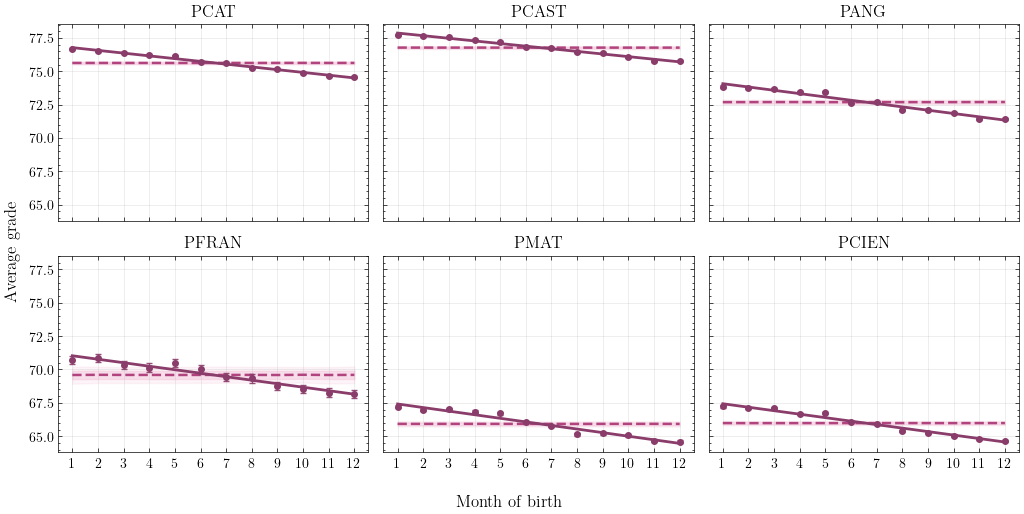

In [42]:
plt.style.use("itxaso.mplstyle")

#--------------------------
#       MULTIPLOT
#--------------------------

# --------------------------------------------------------
# SECONDARY MAIN SUBJECTS
# --------------------------------------------------------
n_iter = 2000

# --------------------------------------------------------
# Multiplot for all Secondary subjects (no legends)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

n_subj = len(subjects_S)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True, sharey=True   # shared axes for consistent comparison
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_S):
    summary_S = secondary_summaries[subj]

    months     = summary_S['month'].values
    real_mean  = summary_S['real_mean'].values
    real_std   = summary_S['real_std'].values    # <-- use SD of grades
    band_mean  = summary_S['null_mean'].values
    band_p16   = summary_S['band_p16'].values
    band_p84   = summary_S['band_p84'].values
    band_p2_5  = summary_S['band_p2_5'].values
    band_p97_5 = summary_S['band_p97_5'].values

    # Colors from your palette dict (secondary)
    band_color  = palette['secondary']['thermalized_band']
    mean_color  = palette['secondary']['thermalized_mean_line']
    point_color = palette['secondary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15
    )

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35
    )

    # Thermalized mean line (no markers)
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None
    )

    # Real mean points (no line between them)
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color
    )

    real_sem = real_std / np.sqrt(summary_S['real_n'].values)
    # Error bars on real means: ± standard deviation of grades
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )


    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        # Regression line (no markers)
        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None
        )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Remove unused axes if grid > number of subjects
for ax in axes[n_subj:]:
    ax.set_visible(False)

for ax in (fig.axes):
    ax.tick_params(axis='x', which='minor', length=0)

# Common labels on outer figure
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

fig.tight_layout()
fig.savefig(
    os.path.join(plot_dir, "secondary_all_subjects_multiplot.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


#### Statistics

In [40]:
plt.style.use("itxaso.mplstyle")

cmap_icefire = sns.color_palette("coolwarm", as_cmap=True)

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)


def plot_summary_heatmaps(df_stats, level_label, filename_prefix):
    """
    df_stats: df_stats_primary_all or df_stats_secondary_all
              must contain columns:
              subject, month, z_score, real_mean, null_mean

    Heatmap colors = Z-score (distance from null in sigmas).
    Cell annotations = Δgrade (real_mean - null_mean), in grade points.
    """
    # Ensure month is numeric and sorted
    df = df_stats.copy()
    df['month'] = pd.to_numeric(df['month'], errors='coerce')
    df = df.dropna(subset=['month'])

    # Sorted unique months
    months_sorted = sorted(df['month'].unique())

    # Desired subject order, depending on level_label
    subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
    subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']

    if level_label.lower().startswith("prim"):
        subject_order = subjects_P
    elif level_label.lower().startswith("sec"):
        subject_order = subjects_S
    else:
        # fallback: whatever subjects appear, in their current order
        subject_order = df['subject'].unique().tolist()

    # --- compute grade difference relative to null ("noise area") ---
    # Δgrade = real_mean - null_mean, in points
    #df['delta_grade'] = df['real_mean'] - df['null_mean']

    # Pivot for colors: Z-scores
    z_pivot = (
        df.pivot_table(index='subject', columns='month', values='z_score')
          .reindex(index=subject_order)       # enforce subject order
          .reindex(columns=months_sorted)     # enforce month order
    )

    # Pivot for annotations: grade differences
    #delta_pivot = (
    #    df.pivot_table(index='subject', columns='month', values='delta_grade')
    #      .reindex(index=subject_order)
    #      .reindex(columns=months_sorted)
    #)

    # --- Z-score heatmap with Δgrade annotations ---
    fig, ax = plt.subplots(figsize=(6, 3.5))

    sns.heatmap(
        z_pivot,
        ax=ax,
        cmap=cmap_icefire,      # color encodes how many sigmas from null
        center=0,
        annot=True,      # numbers shown = z score
        fmt='.2f',              # show Δgrade with 2 decimals
        vmin=-22,
        vmax=22,
        cbar_kws={'label': 'Z-score (distance from null)'}
    )

    # Get rid of tick lines in the heatmap axes
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_title(f'{level_label} – Effect of birth month on grades\n'
    '(color = Z-score, number = grade difference in points)'
    )

    ax.set_ylabel('Subject')
    ax.set_xlabel('Month of birth')

    # Force x tick labels to be 1, 2, 3, ...
    month_labels = [str(int(m)) for m in months_sorted]
    ax.set_xticks(np.arange(len(months_sorted)) + 0.5)  # center ticks on cells
    ax.set_xticklabels(month_labels, rotation=0)

    fig.tight_layout()

    filename = f"{filename_prefix}_zscore_heatmap.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=900, bbox_inches='tight')
    plt.show()



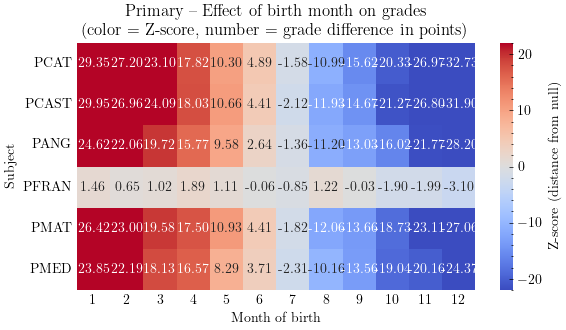

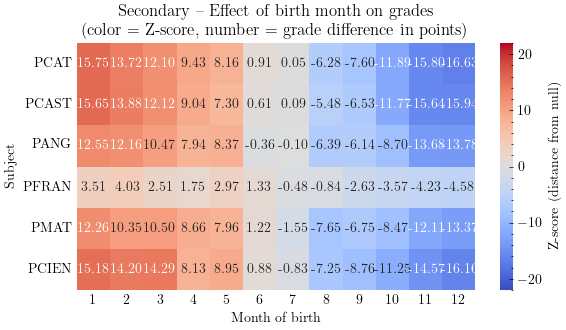

In [41]:
# Calls
plot_summary_heatmaps(df_stats_primary_all,  'Primary',   'primary')
plot_summary_heatmaps(df_stats_secondary_all, 'Secondary', 'secondary')

what I want to show is a comparison between the month effect in secondary vs in primary. I want to see if the difference of one month vs the noise increases or decreases with respect to primary. that is, if older kids "still get smarter" relatively or if the youger kids make a relative improvement in their grades and are less far away to the grades of the older kids.

I saw that the slope in primary is big (more difference bewteen jan-december) and that in secondary that difference is shrinken down. I want a plot that illustrates this

##### “In which subjects and months does Secondary improve more or less than Primary relative to noise?”

In [68]:
plt.style.use("itxaso.mplstyle")

cmap_icefire = sns.color_palette("coolwarm", as_cmap=True)

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)


def plot_zscore_diff_secondary_minus_primary(df_stats_primary_all, df_stats_secondary_all):
    """
    Single heatmap of (Secondary z_score - Primary z_score)
    by subject and month.

    Color: z-score difference (Secondary - Primary), using each level's null.
    Number in each cell: difference in grade improvement relative to null
                         (Secondary delta_grade - Primary delta_grade), in points.

    PMED (Primary) is treated as equivalent to PCIEN (Secondary),
    so PCIEN is renamed to PMED before comparison.
    """

    # --- Preprocess Primary ---
    dfP = df_stats_primary_all.copy()
    dfP['month'] = pd.to_numeric(dfP['month'], errors='coerce')
    dfP = dfP.dropna(subset=['month'])

    # --- Preprocess Secondary ---
    dfS = df_stats_secondary_all.copy()
    dfS['month'] = pd.to_numeric(dfS['month'], errors='coerce')
    dfS = dfS.dropna(subset=['month'])

    # Map Secondary subject codes to Primary equivalents where needed
    subject_map_S_to_P = {'PCIEN': 'PMED'}
    dfS['subject'] = dfS['subject'].replace(subject_map_S_to_P)

    # Explicit subject order (after mapping PCIEN -> PMED)
    subject_order = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']

    # Common sorted months
    months_sorted = sorted(set(dfP['month'].unique()) | set(dfS['month'].unique()))

    # Improvements relative to null ("noise area")
    dfP['delta_grade'] = dfP['real_mean'] - dfP['null_mean']
    dfS['delta_grade'] = dfS['real_mean'] - dfS['null_mean']

    # Pivot to subject × month matrices for z-scores
    zP = (
        dfP.pivot_table(index='subject', columns='month', values='z_score')
           .reindex(index=subject_order, columns=months_sorted)
    )
    zS = (
        dfS.pivot_table(index='subject', columns='month', values='z_score')
           .reindex(index=subject_order, columns=months_sorted)
    )

    # Pivot for delta_grade
    dP = (
        dfP.pivot_table(index='subject', columns='month', values='delta_grade')
           .reindex(index=subject_order, columns=months_sorted)
    )
    dS = (
        dfS.pivot_table(index='subject', columns='month', values='delta_grade')
           .reindex(index=subject_order, columns=months_sorted)
    )

    # Differences
    z_diff = zS - zP
    delta_diff = dS - dP

    # Symmetric color scale around 0 for z_diff
    diff_abs_max = np.nanmax(np.abs(z_diff.values))
    vmin, vmax = -diff_abs_max, diff_abs_max

    fig, ax = plt.subplots(figsize=(6, 3.5))

    sns.heatmap(
        z_diff,
        ax=ax,
        cmap=cmap_icefire,
        vmin=-22, 
        vmax=22,
        center=0,
        annot=delta_diff,
        fmt='.2f',
        cbar_kws={'label': 'Secondary - Primary z-score'}
    )

    ax.set_title(
        'Secondary - Primary: effect of birth month on grades\n'
        '(color = z-score difference, number = grade diff in points)'
    )

    # Y-axis: show that PMED corresponds to PCIEN in the tick label
    ax.set_ylabel('Subject')
    ytick_labels = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED/PCIEN']
    ax.set_yticklabels(ytick_labels, rotation=0)

    ax.set_xlabel('Month of birth')

    # Remove tick lines but keep labels
    ax.tick_params(axis='both', which='both', length=0)

    # X tick labels as 1..12 centered on cells
    month_labels = [str(int(m)) for m in months_sorted]
    ax.set_xticks(np.arange(len(months_sorted)) + 0.5)
    ax.set_xticklabels(month_labels, rotation=0)

    fig.tight_layout()

    filename = "zscore_secondary_minus_primary_heatmap.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=900, bbox_inches='tight')
    plt.show()


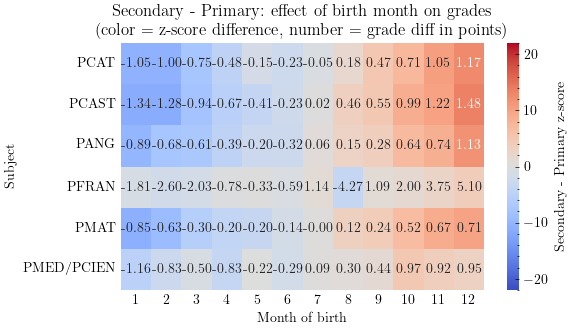

In [69]:
# Call
plot_zscore_diff_secondary_minus_primary(df_stats_primary_all, df_stats_secondary_all)

## Store to share the data across notebooks

In [70]:
%store df_stats_primary_all

Stored 'df_stats_primary_all' (DataFrame)


In [61]:
%store -r df_stats_primary_gender_all

- Fer les regressions lineals i agafar els pendents.

- Randomitzar les dades: com termalitzar, assignar cada nota a un mes de forma aleatòria.

    - Pintar el "fill between" entre les dades randomitzades i les reals.
    - Quan randomitzem, ho fem molts cops. 10, 20, 100 cops, no sé. Llavors, aquestes línies puntejades, fem una "línea gruixida" o ombra.
    - Després, quan pintem les notes mitjanes, volem veure si els punts entren dins d'aquesta regió ombrejada o no. Així podem determinar, amb el grau de confiança que volguem
    (com un 10% dins de la zona ombrejada) si realment aquest comportament entra dins del soroll esperable o no.

- Calcular el Z score.

- Calcular el rang interquartílic.

Use two statistic parameters to improve my study. So far, as I have my thermalized grades with the uncertainty, I can graphically tell that the mean grades by months are out of the thermalized region. That helps me determine that it is not a random fact, but something related to older kids performing better than younger. 

I think it woul be interesting to compute -the Z score. -  interquartílic range. How could I implement this? Also, I only have studied math grades, but I would like to do more. It would be interesting to see, at som point, only one plot that tells the whole story.


entre primaria i secundaria, diferencia entre àrees. en general i per assignatura.

zscore, posar el numero del z score

fer plot inicial violin i boxerrorbars

el multiplot de les notes, separar llengües (una escala) i ciències (una altra)
per intentar que quedi maco.

o millor fer un multiplot on cada assignatura tingui el rang de notes adient (però tots la mateixa escala perquè els pendents es vegin bé)